## Assignment

### Imports

In [1]:
import pydicom
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.draw import polygon, polygon2mask
from skimage import measure
from scipy.ndimage import binary_fill_holes, binary_opening
import plotly.graph_objects as go
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as mpatches
from scipy.interpolate import RegularGridInterpolator

### Read all files

In [2]:
# Folder = Path(r"C:\University\COOP\Hospital Summer 2025\Python Stuff\InitialAssignment\DICOM")
Folder = Path(f"{Path().resolve()}/Tractography_1")

CT_File_Names = []
RD_File_Names = []
RP_File_Names = []
RS_File_Names = []

CT_Files = []
RD_Files = []
RP_Files = []
RS_Files = []

for file in Folder.glob("*.dcm"):
    if file.is_file():
        # print(f"Found file: {file.name}")
        try:
            if "CT" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'CT':
                CT_Files.append(pydicom.dcmread(file)) 
                CT_File_Names.append(file)
            elif "RD" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTDOSE':
                RD_Files.append(pydicom.dcmread(file))
                RD_File_Names.append(file)
            elif "RP" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTPLAN':
                RP_Files.append(pydicom.dcmread(file))
                RP_File_Names.append(file)
            elif "RS" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTSTRUCT':
                RS_Files.append(pydicom.dcmread(file))
                RS_File_Names.append(file)
            else:
                print(f"Unknown DICOM file {file.name}")
        except:
            print(f"Skipped invalid DICOM: {file.name}")

print(f"Found {len(CT_Files)+len(RD_Files)+len(RP_Files)+len(RS_Files)} valid DICOM files")

Found 300 valid DICOM files


### Plot gantry position as function of control point

In [3]:
for Beam in RP_Files[0].BeamSequence:
    print(Beam.BeamType)
    print(Beam.TreatmentDeliveryType+"\n")

DYNAMIC
TREATMENT

DYNAMIC
TREATMENT

STATIC
SETUP

STATIC
SETUP

STATIC
SETUP



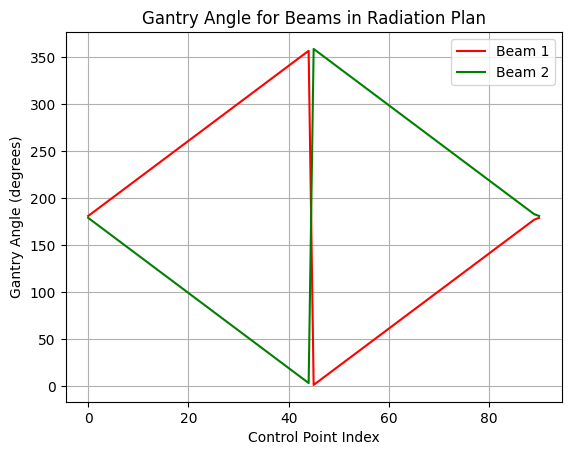

In [4]:
Beams = [beam for beam in RP_Files[0].BeamSequence # only 1 radiation plan file
         if beam.TreatmentDeliveryType.upper() == "TREATMENT"] # only consider treatment beams

gantry_angles = np.full((len(Beams), len(Beams[0].ControlPointSequence)), np.nan) # pre-allocating

for i, beam in enumerate(Beams):
    for j, controlpoint in enumerate(beam.ControlPointSequence):
        try:
            gantry_angles[i, j] = controlpoint.GantryAngle
        except:
            print(f"Skipped gantry angle for beam {i} control point {j}")

colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']

for i in range(np.shape(gantry_angles)[0]):
    plt.plot(gantry_angles[i], label=f"Beam {i+1}", color = colours[i])

plt.legend()
plt.xlabel("Control Point Index")
plt.ylabel("Gantry Angle (degrees)")
plt.title("Gantry Angle for Beams in Radiation Plan")
plt.grid(True)
plt.show()

### Plot 2D view of MLCs (Multi-Leaf Collimators) for one control point

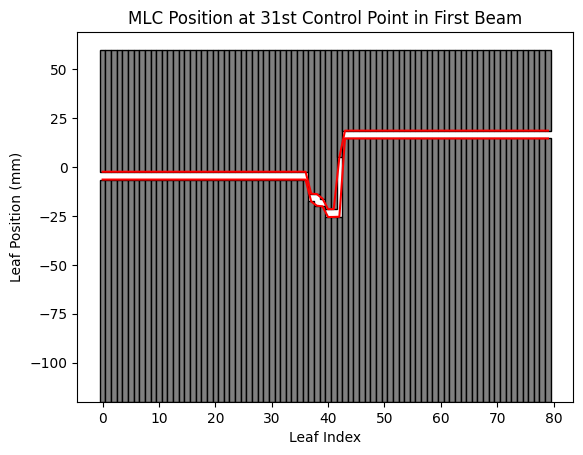

In [5]:
Beams = [beam for beam in RP_Files[0].BeamSequence # only 1 radiation plan file
         if beam.TreatmentDeliveryType.upper() == "TREATMENT"] # only consider treatment beams

beam = Beams[0] # only looking at beam 1 for now

controlpoint = beam.ControlPointSequence[40] # only looking at one control point for now

for device in controlpoint.BeamLimitingDevicePositionSequence:
    if device.RTBeamLimitingDeviceType == "MLCX":
        MLC_positons = device.LeafJawPositions
        MLC_DOWN = MLC_positons[:len(MLC_positons)//2]
        MLC_UP = MLC_positons[len(MLC_positons)//2:]
        plt.plot(MLC_DOWN, color = 'red')
        plt.plot(MLC_UP, color = 'red')
        min_height = -120
        plt.bar(np.arange(len(MLC_DOWN)), height = [leaf - min_height for leaf in MLC_DOWN], width=1.0, bottom=min_height, color='grey', edgecolor = 'black')
        max_height = 60
        plt.bar(np.arange(len(MLC_UP)), height = [max_height - leaf for leaf in MLC_UP], width=1.0, bottom = MLC_UP, color = 'grey', edgecolor = 'black')
        plt.xlabel('Leaf Index')
        plt.ylabel('Leaf Position (mm)')
        plt.title(f"MLC Position at 31st Control Point in First Beam")

        



### Plot the MUs as a function of control point

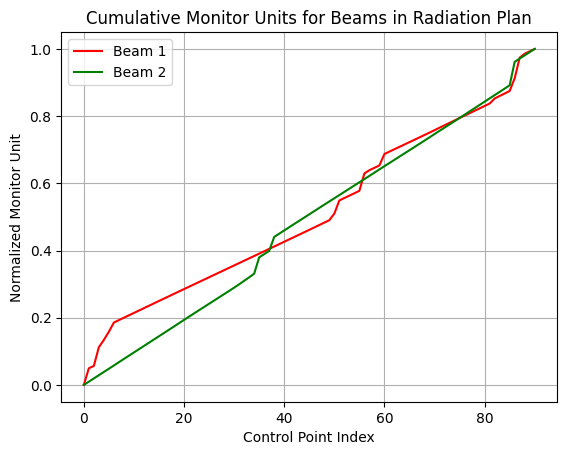

In [6]:
Beams = [beam for beam in RP_Files[0].BeamSequence # only 1 radiation plan file
         if beam.TreatmentDeliveryType.upper() == "TREATMENT"] # only consider treatment beams

monitor_units = np.full((len(Beams), len(Beams[0].ControlPointSequence)), np.nan) # pre-allocating

for i, beam in enumerate(Beams):
    for j, controlpoint in enumerate(beam.ControlPointSequence):
        monitor_units[i, j] = controlpoint.CumulativeMetersetWeight 
        if monitor_units[i, j] == 1:
            monitor_units[i, j:] = 1
            break

colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']

for i in range(np.shape(monitor_units)[0]):
    plt.plot(monitor_units[i], label=f"Beam {i+1}", color = colours[i])

plt.legend()
plt.xlabel("Control Point Index")
plt.ylabel("Normalized Monitor Unit")
plt.title("Cumulative Monitor Units for Beams in Radiation Plan")
plt.grid(True)
plt.show()

### Plot the slice at isocentre of the CT in all three planes (coronal, sagittal and axial) labeled properly

[-165.   -22.2  -92. ]
[ 27.60336 145.5321  145.725  ]
[0.64453125 0.64453125 1.        ]
[299 260 238]


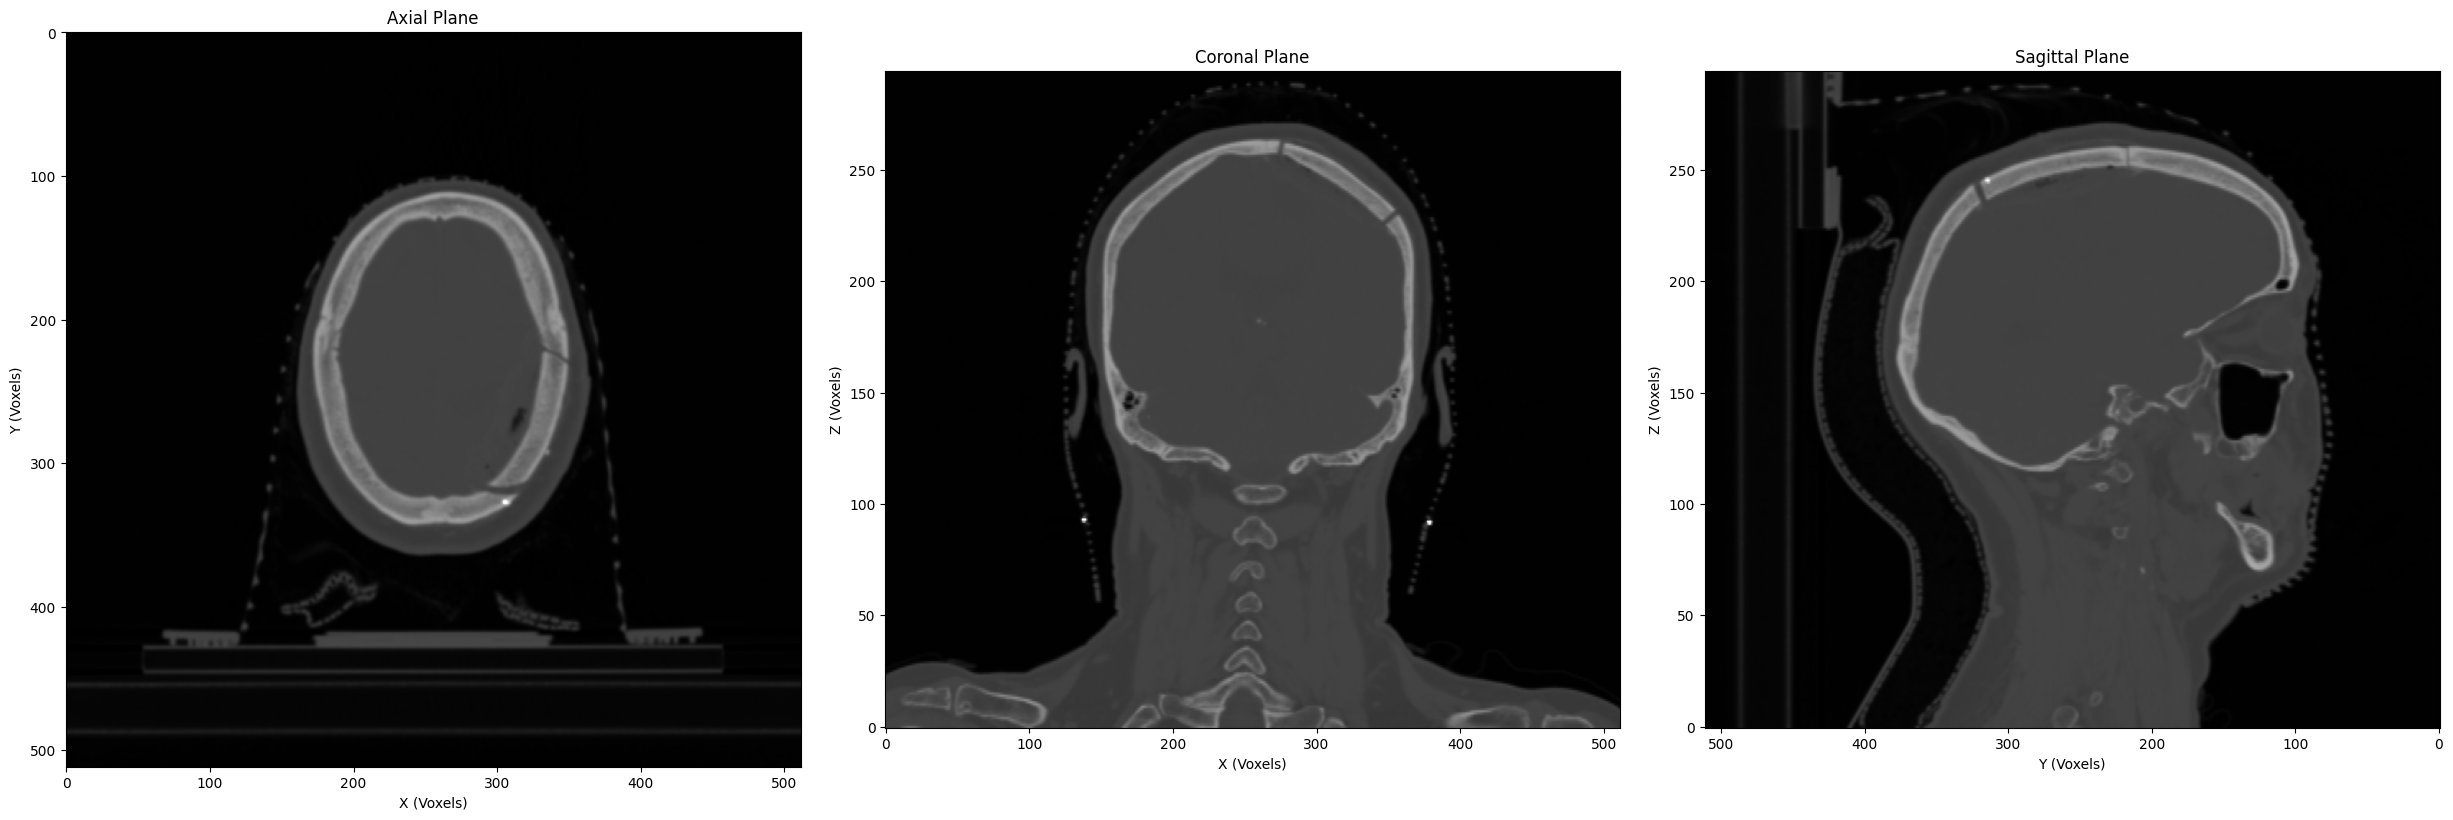

In [7]:
Sorted_CT_Files = sorted(CT_Files, key=lambda file: float(file.ImagePositionPatient[2])) # sort files by z-axis. increasing towards the head
# anatomical orientation type (0010,2210) absent so z-axis is increasing towards the head of the patient

CT_Images = np.stack([slice.pixel_array for slice in Sorted_CT_Files], axis = 2) # make 3d matrix in [y x z]
CT_Images = np.transpose(CT_Images, (1, 0, 2)) # make it [x y z]

pixel_spacing = Sorted_CT_Files[0].PixelSpacing # pixel spacing in mm, [y x]
slice_thickness = Sorted_CT_Files[0].SliceThickness # slice thickness in mm [z]
voxel_spacing = np.array([pixel_spacing[1], pixel_spacing[0], slice_thickness]) # [x y z]
origin = np.array(Sorted_CT_Files[0].ImagePositionPatient) # origin in mm [x y z]
print(origin)

Isocentre_Pos = np.array(RP_Files[0].BeamSequence[0].ControlPointSequence[0].IsocenterPosition) # get isocentre position in mm [x y z]
print(Isocentre_Pos)
print(voxel_spacing)
# print(f"({Isocentre_Pos[2]}-{origin[2]})/{voxel_spacing[2]}")
Isocentre_Pos = np.round((Isocentre_Pos - origin)/voxel_spacing).astype(int)
print(Isocentre_Pos)

# Isocentre_Pos = np.array(RP_Files[0].BeamSequence[0].ControlPointSequence[0].IsocenterPosition) # get isocentre position in mm [x y z]


fig, axs = plt.subplots(1, 3, figsize=(25,25))
plt.tight_layout(pad=3.0)

axs[0].imshow(CT_Images[:, :, Isocentre_Pos[2]].T, origin='upper', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1]) # aspect = dy/dx
# axs[0].imshow(CT_Images[:, :, 230].T, origin='upper', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1])
axs[0].set_title('Axial Plane')
axs[0].set_xlabel('X (Voxels)')
axs[0].set_ylabel('Y (Voxels)')

axs[1].imshow(CT_Images[:, Isocentre_Pos[1], :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
# axs[1].imshow(CT_Images[:, 256, :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
axs[1].set_title('Coronal Plane')
axs[1].set_xlabel('X (Voxels)')
axs[1].set_ylabel('Z (Voxels)')

axs[2].imshow(CT_Images[Isocentre_Pos[0], :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
# axs[2].imshow(CT_Images[256, :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
axs[2].set_title('Sagittal Plane')
axs[2].set_xlabel('Y (Voxels)')
axs[2].set_ylabel('Z (Voxels)')
axs[2].invert_xaxis()

### Overlay the contours of the relevant structures on the image plots

In [8]:
def mm_to_voxel(mm_coords, origin, spacing):
    return np.round((mm_coords-origin)/spacing).astype(int)

In [4]:
# Playground for future to try and figure out this contour stuff...

In [20]:
ROI_Names

{'1': 'PTV1_3000',
 '2': 'GTV1_3000',
 '3': 'BrainStem',
 '4': 'Optic Chiasm',
 '5': 'Lens_L',
 '6': 'Lens_R',
 '7': 'OpticNerve_L',
 '8': 'OpticNerve_R',
 '9': 'Eye_L',
 '10': 'Eye_R',
 '11': 'smoothing ptv contour',
 '12': 'External',
 '13': 'Optics'}

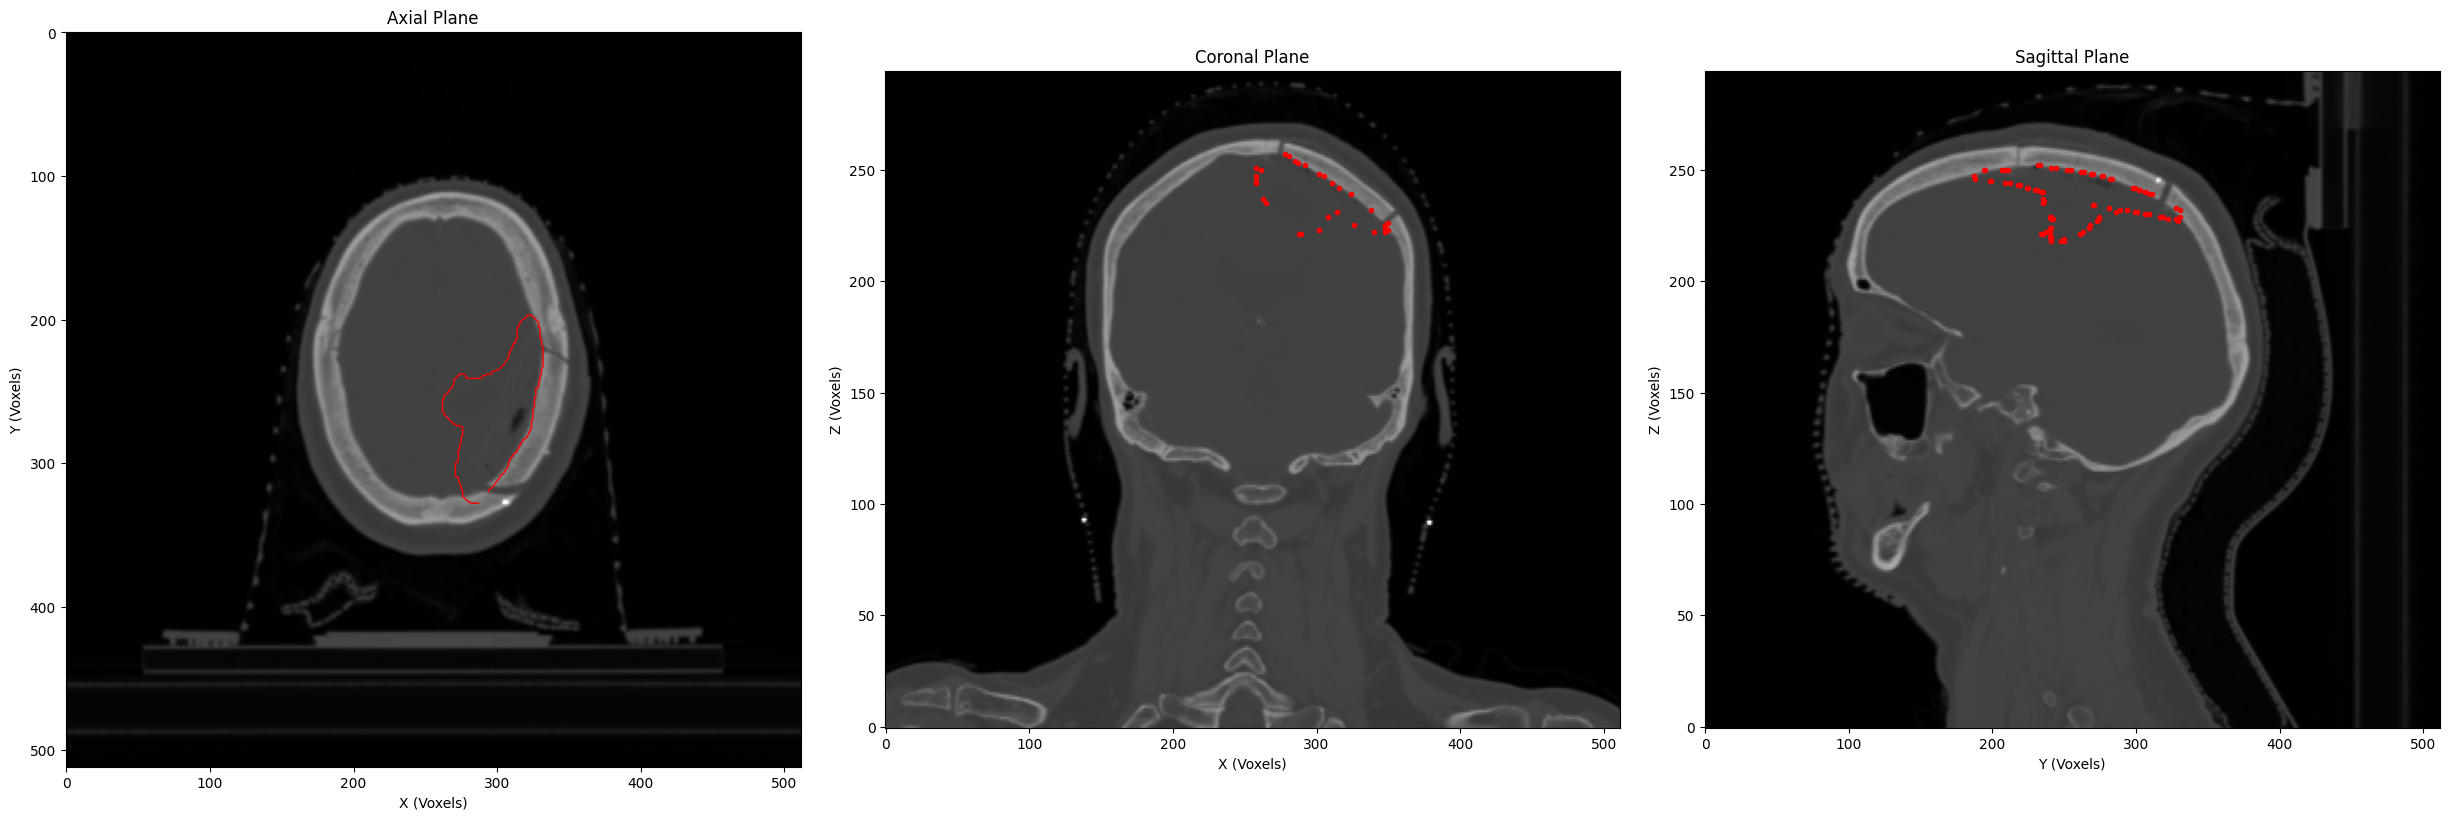

In [9]:
# plot stuff from before
fig, axs = plt.subplots(1, 3, figsize=(25,25))
plt.tight_layout(pad=3.0)

axs[0].imshow(CT_Images[:, :, Isocentre_Pos[2]].T, origin='upper', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1]) # aspect = dy/dx
# axs[0].imshow(CT_Images[:, :, 230].T, origin='upper', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1])
axs[0].set_title('Axial Plane')
axs[0].set_xlabel('X (Voxels)')
axs[0].set_ylabel('Y (Voxels)')

axs[1].imshow(CT_Images[:, Isocentre_Pos[1], :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
# axs[1].imshow(CT_Images[:, 256, :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
axs[1].set_title('Coronal Plane')
axs[1].set_xlabel('X (Voxels)')
axs[1].set_ylabel('Z (Voxels)')

axs[2].imshow(CT_Images[Isocentre_Pos[0], :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
# axs[2].imshow(CT_Images[256, :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
axs[2].set_title('Sagittal Plane')
axs[2].set_xlabel('Y (Voxels)')
axs[2].set_ylabel('Z (Voxels)')

Contour_Sequence = RS_Files[0].ROIContourSequence

ROI_Names = {ROI.ROINumber: 
             ROI.ROIName for ROI in RS_Files[0].StructureSetROISequence}

# Target_Structures = ["1PTV3000", "SpinalCord"]
# Target_Structures = ["1PTV3000"]
Target_Structures = ["PTV1_3000"]
Target_Numbers = np.full(len(Target_Structures), np.nan)

for i, structure in enumerate(Target_Structures):
    for Number, Name in ROI_Names.items():
        if structure.upper() in Name.upper():
            Target_Numbers[i] = Number
            break

for i, Number in enumerate(Target_Numbers):
    for ROI in Contour_Sequence:
        if Number == ROI.ReferencedROINumber:
            Contour_Data = ROI.ContourSequence
    
    contour_points = np.array([]).reshape(0,3)
    for Contour in Contour_Data:
        contour_points_mm = np.array(Contour.ContourData).reshape(-1, 3) # (n, 3) 3 columns in n rows. in mm
        contour_points_slice = np.array([mm_to_voxel(p, origin, voxel_spacing) for p in contour_points_mm])
        contour_points = np.vstack([contour_points, contour_points_slice])
        # if contour_points_slice[0, 2] == Isocentre_Pos[2]: # when on isocentre slice
        #     x_pts, y_pts = contour_points_slice[:, 0], contour_points_slice[:, 1]
        #     axs[0].plot(x_pts, y_pts, 'r-', linewidth = 1)

    # contour_axial = contour_points[(Isocentre_Pos[2]-1 <= contour_points[:, 2])  & (contour_points[:,2] <= Isocentre_Pos[2]+1)] # collect points when on isocentric axial plane
    contour_axial = contour_points[contour_points[:,2] == Isocentre_Pos[2]] # collect points when on isocentric axial plane
    x_pts, y_pts = contour_axial[:, 0], contour_axial[:, 1]
    axs[0].plot(x_pts, y_pts, '-', linewidth = 1, color = colours[i % len(colours)])

    # contour_coronal = contour_points[(Isocentre_Pos[1]-1 <= contour_points[:, 1])  & (contour_points[:,1] <= Isocentre_Pos[1]+1)] # collect points when on isocentric coronal plane
    contour_coronal = contour_points[contour_points[:,1] == Isocentre_Pos[1]] # collect points when on isocentric coronal plane
    x_pts, z_pts = contour_coronal[:,0], contour_coronal[:,2]
    axs[1].plot(x_pts, z_pts, '.', linewidth = 1, color = colours[i % len(colours)])
    # mask = np.zeros((CT_Images[:,0,:].shape)) # pre-allocate mask
    # rr, cc = polygon(contour_coronal[:, 2], contour_coronal[:, 0], shape = mask.shape) # , shape=mask.shape
    # mask[rr, cc] = 1
    # mask = binary_fill_holes(mask) # fill holes for nicer contour
    # contours = find_contours(mask, level=0.5)
    # # contour = max(contours, key = lambda x: len(x))
    # contours = sorted(contours, key = lambda x: len(x))
    # axs[1].plot(contours[-1][:, 1], contours[-1][:, 0], 'r-', linewidth=1)
    # for contour in contours:
    #     axs[1].plot(contour[:, 1], contour[:, 0], 'r-', linewidth=1)

    # contour_sagittal = contour_points[(Isocentre_Pos[0]-1 <= contour_points[:, 0])  & (contour_points[:,0] <= Isocentre_Pos[0]+1)] # collect points when on isocentric sagittal plane
    contour_sagittal = contour_points[contour_points[:, 0] == Isocentre_Pos[0]] # collect points when on isocentric sagittal plane
    y_pts, z_pts = contour_sagittal[:,1], contour_sagittal[:,2]
    axs[2].plot(y_pts, z_pts, '.', linewidth = 1, color = colours[i % len(colours)])
    # mask = np.zeros((CT_Images[:,0,:].shape)) # pre-allocate mask
    # rr, cc = polygon(contour_coronal[:, 2], contour_coronal[:, 1]) # , shape=mask.shape
    # mask[rr, cc] = 1
    # contours = find_contours(mask, level=0.5)
    # contours = sorted(contours, key = lambda x: len(x))
    # axs[2].plot(contours[-1][:, 1], contours[-1][:, 0], 'r-', linewidth=1)
    

    


### 3D visualize the main structures in this plan

In [10]:
def mm_to_voxel(mm_coords, origin, spacing):
    return np.round((mm_coords-origin)/spacing).astype(int)

In [24]:
ROI_Names

{'1': 'PTV1_3000',
 '2': 'GTV1_3000',
 '3': 'BrainStem',
 '4': 'Optic Chiasm',
 '5': 'Lens_L',
 '6': 'Lens_R',
 '7': 'OpticNerve_L',
 '8': 'OpticNerve_R',
 '9': 'Eye_L',
 '10': 'Eye_R',
 '11': 'smoothing ptv contour',
 '12': 'External',
 '13': 'Optics'}

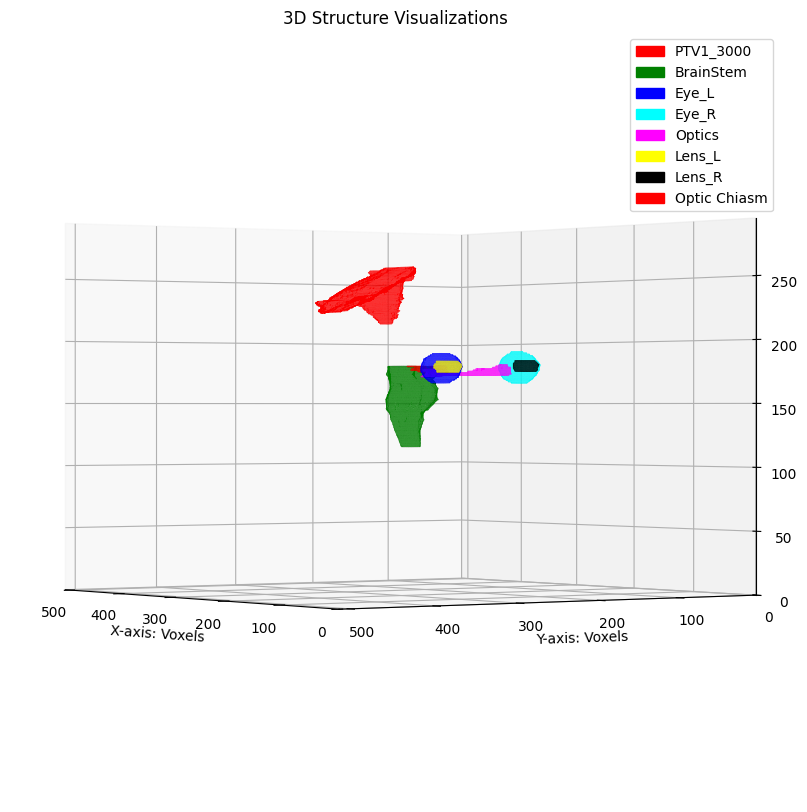

In [12]:
# Create dictionary of ROI names and numbers from structure file
ROI_Names = {ROI.ROINumber: ROI.ROIName for ROI in RS_Files[0].StructureSetROISequence}

# Define structures of interest to the user. Need to consult ROI_Names to do this
# Target_Structures = ["1GTV3000", "1PTV3000", "SpinalCord", "Brain", "Eye_L", "Eye_R"]
# Target_Structures = ["1PTV3000"]
Target_Structures = ["PTV1_3000", "BrainStem", "Eye_L", "Eye_R", "Optics", "Lens_L", "Lens_R", "Optic Chiasm"]
Target_Numbers = np.full(len(Target_Structures), np.nan) # pre-allocate Target_Numbers

# Fill in Target_Numbers
for i, structure in enumerate(Target_Structures): # loop through every structure name of interest
    for Number, Name in ROI_Names.items(): # loop through dictionary until there is a match
        if structure.upper() in Name.upper():
            Target_Numbers[i] = Number
            break

# Create a 3d plot for visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')

# Define colours array
colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']

# Define contour sequence
Contour_Sequence = RS_Files[0].ROIContourSequence

# Pre-allocate something to contain all masks
all_masks = []

# Get contour data from every target structure, by verifying ROI number
for i, Number in enumerate(Target_Numbers):
    for ROI in Contour_Sequence:
        if ROI.ReferencedROINumber == Number:
            Contour_Data = ROI.ContourSequence
            break

    # Get contour points and make 3D mask
    # contour_points = np.array([]).reshape(0,3) # pre-allocate matrix of all contour points
    mask = np.zeros(CT_Images[:, :, :].shape) # pre-allocate mask
    for Contour in Contour_Data: # get the contour points in every slice
        contour_points_mm = np.array(Contour.ContourData).reshape(-1, 3) # (n, 3) 3 columns in n rows. in mm
        contour_points_slice = np.array([mm_to_voxel(p, origin, voxel_spacing) for p in contour_points_mm])
        # contour_points = np.vstack([contour_points, contour_points_slice]) # add slice to matrix
        rr, cc = polygon(contour_points_slice[:,1], contour_points_slice[:,0], CT_Images[:, :, 0].shape)
        mask[rr, cc, contour_points_slice[0,2]] = 1

    # Extract surface mesh with marching cubes
    verts, faces, normals, values = measure.marching_cubes(mask, level=0.5) 

    # Append masks to all_masks variable
    all_masks.append(mask)
    
    # Create mesh (collection of triangles?) from vertices and faces
    mesh = Poly3DCollection(verts[faces], alpha = 0.7)
    mesh.set_facecolor(colours[i % len(colours)])
    ax.add_collection3d(mesh)

# Set labels and axis limits
ax.set_xlabel("X-axis: Voxels")
ax.set_ylabel("Y-axis: Voxels")
ax.set_zlabel("Z-axis: Slices")
ax.set_title("3D Structure Visualizations")
ax.set_xlim(0, mask.shape[0])
ax.set_ylim(0, mask.shape[1])
ax.set_zlim(0, mask.shape[2])

# Create a legend
legend_patches = [
    mpatches.Patch(color=colours[i % len(colours)], label=Target_Structures[i])
    for i in range(len(Target_Structures))
]
ax.legend(handles = legend_patches, loc = 'upper right')

# Change viewing angle
ax.view_init(0, 145) # elevation, azimuth

In [ ]:
# Plotting with matplotlib

# Extract surface mesh with marching cubes
verts, faces, normals, values = measure.marching_cubes(mask, level=0.5)

# Create a 3d plot for visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')

# Create mesh (collection of triangles?) from vertices and faces
mesh = Poly3DCollection(verts[faces], alpha = 0.7)
mesh.set_facecolor('b')
# mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

# Set labels and axis limits
ax.set_xlabel("X-axis: Voxels")
ax.set_ylabel("Y-axis: Voxels")
ax.set_zlabel("Z-axis: Slices")
ax.set_xlim(0, mask.shape[0])
ax.set_ylim(0, mask.shape[1])
ax.set_zlim(0, mask.shape[2])

#### Plotly (mask too big for this i think)

In [ ]:
fig = go.Figure(data=go.Isosurface(
    x = np.arange(CT_Images.shape[0]),
    y = np.arange(CT_Images.shape[1]),
    z = np.arange(CT_Images.shape[2]),
    value = mask.flatten(),
    isomin = 0.5,
    isomax = 1,
    opacity = 0.7,
    surface_count = 1,
    caps = dict(x_show = False, y_show = False, z_show = False)
))

fig.update_layout(
    scene=dict(
        xaxis_title='X (voxels)',
        yaxis_title='Y (voxels)',
        zaxis_title='Z (slices)',
        aspectmode = 'cube'
    ),
    title="3D Structure Visualization"
)

fig.show()


#### Plotly test

In [14]:
import numpy as np
import plotly.graph_objects as go

# Define grid size and create a 3D coordinate grid
size = 30
x, y, z = np.mgrid[0:size, 0:size, 0:size]

# Create a 3D binary mask for a sphere
center = np.array([15, 15, 15])
radius = 10
sphere_mask = ((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2) < radius**2

# Confirm there are True values
print("Number of True voxels:", sphere_mask.sum())  # Should be > 0

# Plot the 3D mask using Isosurface (treating the boolean mask as volume)
fig = go.Figure(data=go.Isosurface(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=sphere_mask.astype(np.uint8).flatten(),  # Convert to 0 and 1
    isomin=0.5,  # anything > 0.5 is treated as "inside"
    isomax=1.0,
    opacity=0.6,
    surface_count=1,
    colorscale='Blues',
    caps=dict(x_show=False, y_show=False, z_show=False)
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube'
    ),
    title='Working 3D Sphere Visualization'
)

fig.show()


Number of True voxels: 4139


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Align 3D dose volume with the CT coordinates

In [9]:
def mm_to_voxel(mm_coords, origin, spacing):
    return np.round((mm_coords-origin)/spacing).astype(int)

#### Manual Method

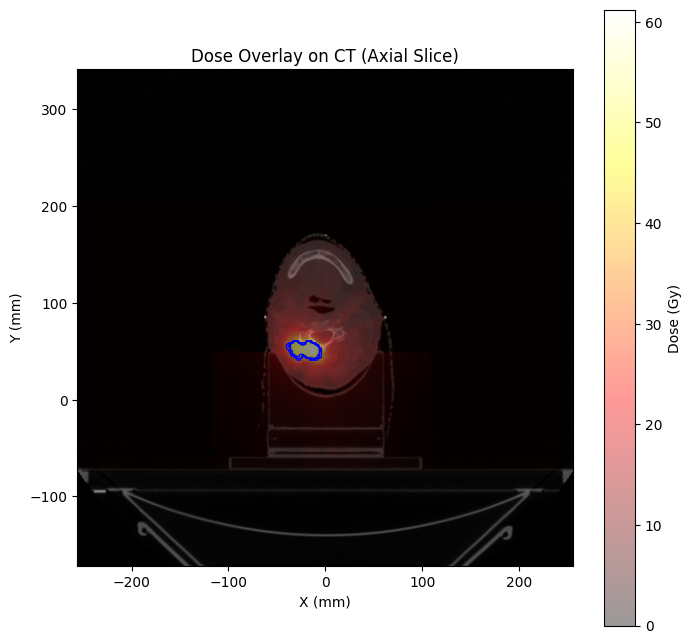

In [16]:
# Define some parameters from the dose file(s)
dose_origin = RD_Files[0].ImagePositionPatient # Origin for the dose files. All have the same origin
dose_pixel_spacing = RD_Files[0].PixelSpacing # Pixel spacing for the dose files. All have the same spacing. In mm. [y x]
dose_slice_thickness = RD_Files[0].SliceThickness # Slice thickness for the dose files. All have the same thickness. In mm. [z]
dose_voxel_spacing = np.array([dose_pixel_spacing[1], dose_pixel_spacing[0], dose_slice_thickness]) # Voxel spacing for the dose files. [x y z]
dose_images = np.transpose(RD_Files[0].pixel_array, (2, 1, 0)) # Take dose array and make it [x y z]. Starts off as [z y x]

# Convert the dose origin to "generic" coords (still in mm)
dose_centre_world = dose_origin + dose_voxel_spacing * np.array(dose_images.shape) / 2 # Shift origin to centre by taking the shape and multiplying the spacing and dividing by 2, then adding the origin

# From this dose centre find corresponding CT voxel coordinates
ct_voxel_centre = mm_to_voxel(dose_centre_world, origin, voxel_spacing)

# Find slice index and corresponding CT image characteristics for that slice
slice_index = ct_voxel_centre[2]
ct_slice = CT_Images[:, :, slice_index]

# Find dose voxel index now
dose_voxel_index = np.round((ct_voxel_centre - (np.array(dose_origin) - np.array(origin))) / dose_voxel_spacing).astype(int)
dose_slice = dose_images[:, :, dose_voxel_index[2]]

# Define exents
ct_extent = [
    origin[0], # x_min (mm)
    origin[0] + ct_slice.shape[0] * voxel_spacing[0], # x_max (mm)
    origin[1], # y_min (mm)
    origin[1] + ct_slice.shape[1] * voxel_spacing[1], # y_max (mm)
]

dose_extent = [
    dose_origin[0], # x_min (mm)
    dose_origin[0] + dose_slice.shape[0] * dose_voxel_spacing[0], # x_max (mm)
    dose_origin[1] - 42, # y_min (mm) # 42 manually inputted
    dose_origin[1] + dose_slice.shape[1] * dose_voxel_spacing[1] - 42, # y_max (mm) # 42 manually inputted
]

# Plot
plt.figure(figsize=(8, 8))
# plt.imshow(ct_slice.T, cmap='gray', origin='upper', alpha=1.0)
plt.imshow(ct_slice.T, cmap='gray', origin='upper', extent = ct_extent, alpha=1.0)
plt.imshow(dose_slice.T/1000, cmap='hot', origin='upper', extent = dose_extent, alpha=0.4)
# plt.imshow(dose_slice.T/1000, cmap='hot', origin='upper', alpha=0.4)
# plt.imshow(ct_slice.T, cmap='gray', origin='upper', alpha=1.0)
plt.title("Dose Overlay on CT (Axial Slice)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.colorbar(label="Dose (Gy)")

contour_axial = contour_points[(slice_index-1 <= contour_points[:, 2])  & (contour_points[:,2] <= slice_index+1)] # collect points when on same slice as this figure
x_pts, y_pts = contour_axial[:, 0], contour_axial[:, 1]
plt.plot(x_pts + ct_extent[0], ct_extent[3] - y_pts, 'b-', linewidth = 1)
# plt.plot(x_pts, y_pts, 'b-', linewidth = 1)

plt.show()




In [ ]:
mm_to_voxel(dose_origin, origin, voxel_spacing)

In [ ]:
print(dose_origin)
print(dose_origin + dose_voxel_spacing * np.array(dose_images.shape) / 2)
print(dose_origin + dose_voxel_spacing * np.array(dose_images.shape))
print("\n")
print(origin)
print(origin + voxel_spacing * np.array(CT_Images.shape) / 2)
print(origin + voxel_spacing * np.array(CT_Images.shape))

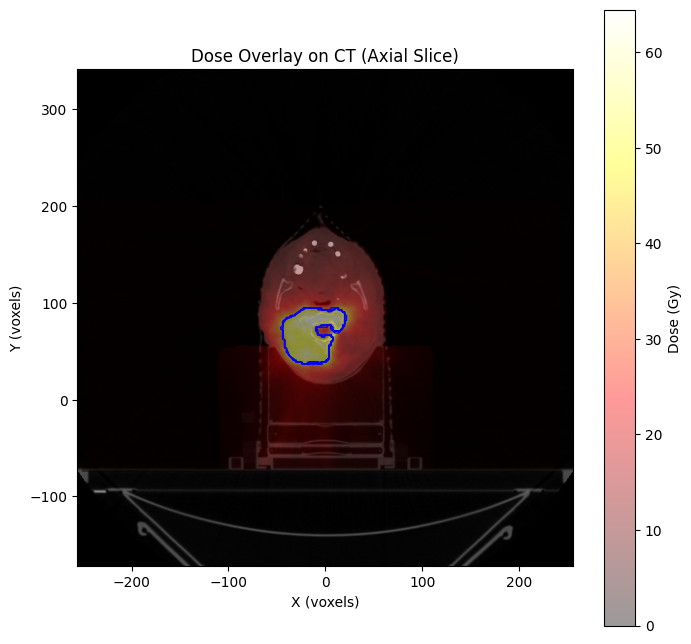

In [17]:
# From isocentre axial view, convert to dose array stuff

# First define stuff from dose
# Define some parameters from the dose file(s)
dose_origin = RD_Files[0].ImagePositionPatient # Origin for the dose files. All have the same origin
dose_pixel_spacing = RD_Files[0].PixelSpacing # Pixel spacing for the dose files. All have the same spacing. In mm. [y x]
dose_slice_thickness = RD_Files[0].SliceThickness # Slice thickness for the dose files. All have the same thickness. In mm. [z]
dose_voxel_spacing = np.array([dose_pixel_spacing[1], dose_pixel_spacing[0], dose_slice_thickness]) # Voxel spacing for the dose files. [x y z]
dose_images = np.transpose(RD_Files[0].pixel_array, (2, 1, 0)) # Take dose array and make it [x y z]. Starts off as [z y x]

# Define CT voxel centre from isocentre
# From this dose centre find corresponding CT voxel coordinates
ct_voxel_centre = Isocentre_Pos

# Find slice index and corresponding CT image characteristics for that slice
slice_index = ct_voxel_centre[2]
ct_slice = CT_Images[:, :, slice_index]

# Find dose voxel index now
dose_voxel_index = np.round((ct_voxel_centre - (np.array(dose_origin) - np.array(origin))) / dose_voxel_spacing).astype(int)
dose_slice = dose_images[:, :, dose_voxel_index[2]]

# Define exents
ct_extent = [
    origin[0], # x_min (mm)
    origin[0] + ct_slice.shape[0] * voxel_spacing[0], # x_max (mm)
    origin[1], # y_min (mm)
    origin[1] + ct_slice.shape[1] * voxel_spacing[1], # y_max (mm)
]

dose_extent = [
    dose_origin[0], # x_min (mm)
    dose_origin[0] + dose_slice.shape[0] * dose_voxel_spacing[0], # x_max (mm)
    dose_origin[1] - 42, # y_min (mm)
    dose_origin[1] + dose_slice.shape[1] * dose_voxel_spacing[1] - 42, # y_max (mm)
]
# Plot
plt.figure(figsize=(8, 8))
plt.imshow(ct_slice.T, cmap='gray', origin='upper', extent = ct_extent, alpha=1.0)
plt.imshow(dose_slice.T/1000, cmap='hot', origin='upper', extent = dose_extent, alpha=0.4)
# plt.imshow(ct_slice.T, cmap='gray', origin='upper', alpha=1.0)
plt.title("Dose Overlay on CT (Axial Slice)")
plt.xlabel("X (voxels)")
plt.ylabel("Y (voxels)")
plt.colorbar(label="Dose (Gy)")

# Find contour from that slice and plot
contour_axial = contour_points[(slice_index-1 <= contour_points[:, 2])  & (contour_points[:,2] <= slice_index+1)] # collect points when on same slice as this figure
x_pts, y_pts = contour_axial[:, 0], contour_axial[:, 1]
plt.plot(x_pts + ct_extent[0], ct_extent[3] - y_pts, 'b-', linewidth = 1)

plt.show()

In [ ]:
RD_Files[0].GridFrameOffsetVector
# CT_Files[0].pixel_array

In [ ]:
for i in range(len(RD_Files)):
    print(RD_Files[i].PixelSpacing)
    print(RD_Files[i].SliceThickness)
    print(RD_Files[i].ImagePositionPatient)
    print(RD_Files[i].DoseType)
    print(RD_Files[i].DoseUnits)
    print(RD_Files[i].pixel_array.shape)
    print("\n")

In [ ]:
for i, rd in enumerate(RD_Files):
    print(f"File {i}")
    print(f"  Dose Summation Type: {rd.DoseSummationType}")
    print(f"  SOP Instance UID: {rd.SOPInstanceUID}")
    print(f"  Referenced RT Plan UID: {rd.ReferencedRTPlanSequence[0].ReferencedSOPInstanceUID}")
    print(f"  Dose Grid Scaling: {rd.DoseGridScaling}")
    print(f"  Dose Units: {rd.DoseUnits}")
    print()


In [ ]:
RD_Files[0]

#### Interpolation Method

In [6]:
# Defining stuff

Sorted_CT_Files = sorted(CT_Files, key=lambda file: float(file.ImagePositionPatient[2])) # sort files by z-axis. increasing towards the head
# anatomical orientation type (0010,2210) absent so z-axis is increasing towards the head of the patient

CT_Images = np.stack([slice.pixel_array for slice in Sorted_CT_Files], axis = 2) # make 3d matrix in [y x z]
CT_Images = np.transpose(CT_Images, (1, 0, 2)) # make it [x y z]

pixel_spacing = Sorted_CT_Files[0].PixelSpacing # pixel spacing in mm, [y x]
slice_thickness = Sorted_CT_Files[0].SliceThickness # slice thickness in mm [z]
voxel_spacing = np.array([pixel_spacing[1], pixel_spacing[0], slice_thickness]) # [x y z]
origin = np.array(Sorted_CT_Files[0].ImagePositionPatient) # origin in mm [x y z]

# First define stuff from dose
# Define some parameters from the dose file(s)
dose_origin = RD_Files[0].ImagePositionPatient # Origin for the dose files. All have the same origin
dose_pixel_spacing = RD_Files[0].PixelSpacing # Pixel spacing for the dose files. All have the same spacing. In mm. [y x]
dose_slice_thickness = RD_Files[0].SliceThickness # Slice thickness for the dose files. All have the same thickness. In mm. [z]
dose_voxel_spacing = np.array([dose_pixel_spacing[1], dose_pixel_spacing[0], dose_slice_thickness]) # Voxel spacing for the dose files. [x y z]
dose_images = np.transpose(RD_Files[0].pixel_array, (2, 1, 0)) # Take dose array and make it [x y z]. Starts off as [z y x]

# Define isocentre
Isocentre_Pos = np.array(RP_Files[0].BeamSequence[0].ControlPointSequence[0].IsocenterPosition) # get isocentre position in mm [x y z]
Isocentre_Pos = np.round((Isocentre_Pos - origin)/voxel_spacing).astype(int) # get isocentre in terms of voxels

In [10]:
# Get masks/contours

# Create dictionary of ROI names and numbers from structure file
ROI_Names = {ROI.ROINumber: ROI.ROIName for ROI in RS_Files[0].StructureSetROISequence}

# Define structures of interest to the user. Need to consult ROI_Names to do this
# Target_Structures = ["1GTV3000", "1PTV3000", "SpinalCord", "Brain", "Eye_L", "Eye_R"]
# Target_Structures = ["1PTV3000"]
# Target_Structures = ["PTV1_3000", "BrainStem", "Eye_L", "Eye_R", "Optics", "Lens_L", "Lens_R", "Optic Chiasm"]
Target_Structures = ["PTV1_3000"]

Target_Numbers = np.full(len(Target_Structures), np.nan) # pre-allocate Target_Numbers

# Fill in Target_Numbers
for i, structure in enumerate(Target_Structures): # loop through every structure name of interest
    for Number, Name in ROI_Names.items(): # loop through dictionary until there is a match
        if structure.upper() in Name.upper():
            Target_Numbers[i] = Number
            break

# Define contour sequence
Contour_Sequence = RS_Files[0].ROIContourSequence

# Pre-allocate something to contain all masks
all_masks = []

# Get contour data from every target structure, by verifying ROI number
for i, Number in enumerate(Target_Numbers):
    for ROI in Contour_Sequence:
        if ROI.ReferencedROINumber == Number:
            Contour_Data = ROI.ContourSequence
            break

    # Get contour points and make 3D mask
    # contour_points = np.array([]).reshape(0,3) # pre-allocate matrix of all contour points
    mask = np.zeros(CT_Images[:, :, :].shape) # pre-allocate mask
    for Contour in Contour_Data: # get the contour points in every slice
        contour_points_mm = np.array(Contour.ContourData).reshape(-1, 3) # (n, 3) 3 columns in n rows. in mm
        contour_points_slice = np.array([mm_to_voxel(p, origin, voxel_spacing) for p in contour_points_mm])
        # contour_points = np.vstack([contour_points, contour_points_slice]) # add slice to matrix
        rr, cc = polygon(contour_points_slice[:,1], contour_points_slice[:,0], CT_Images[:, :, 0].shape)
        mask[cc, rr, contour_points_slice[0,2]] = 1

    # Extract surface mesh with marching cubes
    # verts, faces, normals, values = measure.marching_cubes(mask, level=0.5) 

    # Append masks to all_masks variable
    all_masks.append(mask.astype(bool))
    
    # Create mesh (collection of triangles?) from vertices and faces
    # mesh = Poly3DCollection(verts[faces], alpha = 0.7)
    # mesh.set_facecolor(colours[i % len(colours)])


In [4]:
# Trying now with the interpolate method

# Need to interpolate from dose to shape it towards ct scan

# Get grid for x, y, z from the ct mask in mm to make a an array of every possible point
z = np.arange(len(CT_Files)) * voxel_spacing[2] + origin[2] # z
y = np.arange(512) * voxel_spacing[1] + origin[1] # y
x = np.arange(512) * voxel_spacing[0] + origin[0] # x
X, Y, Z = np.meshgrid(x, y, z, indexing = 'ij')
points = np.stack((X.flatten(), Y.flatten(), Z.flatten()), axis = -1) # makes array of every possible point in [x y z]

# Get the dose points in mm for x, y, z
dose_z = np.arange(dose_images.shape[2]) * dose_voxel_spacing[2] + dose_origin[2]
dose_y = np.arange(dose_images.shape[1]) * dose_voxel_spacing[1] + dose_origin[1]
dose_x = np.arange(dose_images.shape[0]) * dose_voxel_spacing[0] + dose_origin[0]

# Define interpolating function. Bounds_error false so we can go outside of the bounds and fill_value is 0 so outside of bounds is 0
interpolator = RegularGridInterpolator((dose_x, dose_y, dose_z), dose_images, bounds_error = False, fill_value = 0)

# Fit dose to 512 x 512 x 464 grid (same as CT image/mas shape)
dose_resampled = interpolator(points).reshape(CT_Images.shape)

NameError: name 'contour_points' is not defined

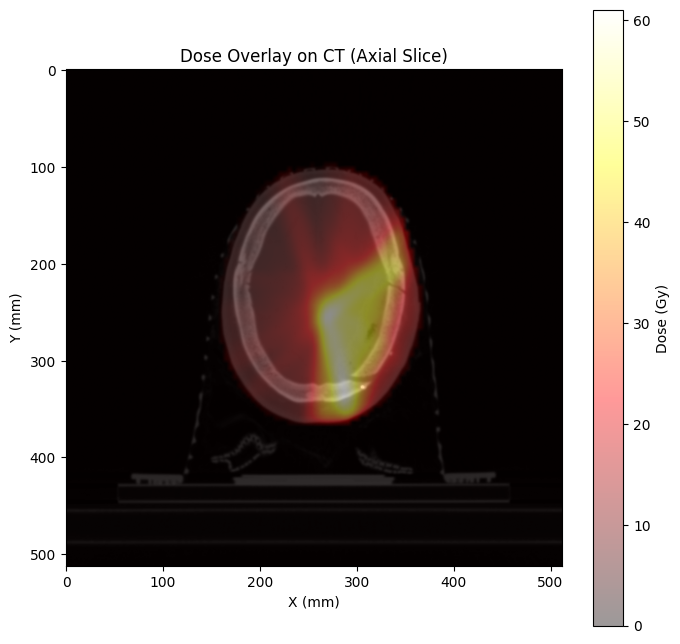

In [11]:
# Define CT voxel centre from isocentre
# From this dose centre find corresponding CT voxel coordinates
ct_voxel_centre = Isocentre_Pos

# Find slice index and corresponding CT image characteristics for that slice
slice_index = ct_voxel_centre[2]
ct_slice = CT_Images[:, :, slice_index]

dose_slice_resampled = dose_resampled[:, :, slice_index] # same slice index as ct_slice

# Plot
plt.figure(figsize=(8, 8))
# plt.imshow(ct_slice.T, cmap='gray', origin='upper', alpha=1.0)
plt.imshow(ct_slice.T, cmap='gray', origin='upper', alpha=1.0)
plt.imshow(dose_slice_resampled.T/1000, cmap='hot', origin='upper', alpha=0.4)
# plt.imshow(dose_slice.T/1000, cmap='hot', origin='upper', alpha=0.4)
# plt.imshow(ct_slice.T, cmap='gray', origin='upper', alpha=1.0)
plt.title("Dose Overlay on CT (Axial Slice)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.colorbar(label="Dose (Gy)")

contour_axial = contour_points[(slice_index-1 <= contour_points[:, 2])  & (contour_points[:,2] <= slice_index+1)] # collect points when on same slice as this figure
x_pts, y_pts = contour_axial[:, 0], contour_axial[:, 1]
# plt.plot(x_pts + ct_extent[0], ct_extent[3] - y_pts, 'b-', linewidth = 1)
plt.plot(x_pts, y_pts, 'b-', linewidth = 1)

plt.show()

### Dose-Volume-Histogram

In [31]:
# Defining stuff

Sorted_CT_Files = sorted(CT_Files, key=lambda file: float(file.ImagePositionPatient[2])) # sort files by z-axis. increasing towards the head
# anatomical orientation type (0010,2210) absent so z-axis is increasing towards the head of the patient

CT_Images = np.stack([slice.pixel_array for slice in Sorted_CT_Files], axis = 2) # make 3d matrix in [y x z]
CT_Images = np.transpose(CT_Images, (1, 0, 2)) # make it [x y z]

pixel_spacing = Sorted_CT_Files[0].PixelSpacing # pixel spacing in mm, [y x]
slice_thickness = Sorted_CT_Files[0].SliceThickness # slice thickness in mm [z]
voxel_spacing = np.array([pixel_spacing[1], pixel_spacing[0], slice_thickness]) # [x y z]
origin = np.array(Sorted_CT_Files[0].ImagePositionPatient) # origin in mm [x y z]

# First define stuff from dose
# Define some parameters from the dose file(s)
dose_origin = RD_Files[0].ImagePositionPatient # Origin for the dose files. All have the same origin
dose_pixel_spacing = RD_Files[0].PixelSpacing # Pixel spacing for the dose files. All have the same spacing. In mm. [y x]
dose_slice_thickness = RD_Files[0].SliceThickness # Slice thickness for the dose files. All have the same thickness. In mm. [z]
dose_voxel_spacing = np.array([dose_pixel_spacing[1], dose_pixel_spacing[0], dose_slice_thickness]) # Voxel spacing for the dose files. [x y z]
dose_images = np.transpose(RD_Files[1].pixel_array, (2, 1, 0)) # Take dose array and make it [x y z]. Starts off as [z y x]

In [32]:
def mm_to_voxel(mm_coords, origin, spacing):
    return np.round((mm_coords-origin)/spacing).astype(int)

In [33]:
# Get masks

# Create dictionary of ROI names and numbers from structure file
ROI_Names = {ROI.ROINumber: ROI.ROIName for ROI in RS_Files[0].StructureSetROISequence}

# Define structures of interest to the user. Need to consult ROI_Names to do this
# Target_Structures = ["1GTV3000", "1PTV3000", "SpinalCord", "Brain", "Eye_L", "Eye_R"]
# Target_Structures = ["1PTV3000"]
# Target_Structures = ["PTV1_3000", "BrainStem", "Eye_L", "Eye_R", "Optics", "Lens_L", "Lens_R", "Optic Chiasm"]
Target_Structures = ["PTV1_3000"]
Target_Numbers = np.full(len(Target_Structures), np.nan) # pre-allocate Target_Numbers

# Fill in Target_Numbers
for i, structure in enumerate(Target_Structures): # loop through every structure name of interest
    for Number, Name in ROI_Names.items(): # loop through dictionary until there is a match
        if structure.upper() in Name.upper():
            Target_Numbers[i] = Number
            break

# Define contour sequence
Contour_Sequence = RS_Files[0].ROIContourSequence

# Pre-allocate something to contain all masks
all_masks = []

# Get contour data from every target structure, by verifying ROI number
for i, Number in enumerate(Target_Numbers):
    for ROI in Contour_Sequence:
        if ROI.ReferencedROINumber == Number:
            Contour_Data = ROI.ContourSequence
            break

    # Get contour points and make 3D mask
    # contour_points = np.array([]).reshape(0,3) # pre-allocate matrix of all contour points
    mask = np.zeros(CT_Images[:, :, :].shape) # pre-allocate mask
    for Contour in Contour_Data: # get the contour points in every slice
        contour_points_mm = np.array(Contour.ContourData).reshape(-1, 3) # (n, 3) 3 columns in n rows. in mm
        contour_points_slice = np.array([mm_to_voxel(p, origin, voxel_spacing) for p in contour_points_mm])
        # contour_points = np.vstack([contour_points, contour_points_slice]) # add slice to matrix
        rr, cc = polygon(contour_points_slice[:,1], contour_points_slice[:,0], CT_Images[:, :, 0].shape)
        mask[cc, rr, contour_points_slice[0,2]] = 1

    # Extract surface mesh with marching cubes
    # verts, faces, normals, values = measure.marching_cubes(mask, level=0.5) 

    # Append masks to all_masks variable
    all_masks.append(mask.astype(bool))
    
    # Create mesh (collection of triangles?) from vertices and faces
    # mesh = Poly3DCollection(verts[faces], alpha = 0.7)
    # mesh.set_facecolor(colours[i % len(colours)])


In [7]:
# Need to interpolate from dose to shape it towards ct scan

# Get grid for x, y, z from the ct mask in mm to make a an array of every possible point
z = np.arange(mask.shape[2]) * voxel_spacing[2] + origin[2]
y = np.arange(mask.shape[1]) * voxel_spacing[1] + origin[1]
x = np.arange(mask.shape[0]) * voxel_spacing[0] + origin[0]
# X, Y, Z = np.meshgrid(x, y, z, indexing = 'ij')
# points = np.stack((X.flatten(), Y.flatten(), Z.flatten()), axis = -1) # makes array of every possible point in [x y z]

# Get the dose points in mm for x, y, z
dose_z = np.arange(dose_images.shape[2]) * dose_voxel_spacing[2] + dose_origin[2]
dose_y = np.arange(dose_images.shape[1]) * dose_voxel_spacing[1] + dose_origin[1]
dose_x = np.arange(dose_images.shape[0]) * dose_voxel_spacing[0] + dose_origin[0]

# Define interpolating function. Bounds_error false so we can go outside of the bounds and fill_value is 0 so outside of bounds is 0
interpolator = RegularGridInterpolator((dose_x, dose_y, dose_z), dose_images, bounds_error = False, fill_value = 0)

# This way takes way too long lol impossible
# dose_resampled = np.zeros((len(x), len(y), len(z)))
# for i in range(len(x)):
#     for j in range(len(y)):
#         for k in range(len(z)):
#             dose_resampled[i, j, k] = (interpolator([[x[i], y[j], z[k]]]))[0]

# Fit dose to 512 x 512 x 464 grid (same as CT image/mask shape)
dose_resampled = interpolator(points).reshape(CT_Images.shape)

NameError: name 'points' is not defined

In [20]:
RD_Files[1].DoseSummationType

'PLAN'

In [34]:
# Interpolating from CT_images shape to dose_image shape

# Get grid for x, y, z from the ct mask in mm to make a an array of every possible point
z = np.arange(mask.shape[2]) * voxel_spacing[2] + origin[2]
y = np.arange(mask.shape[1]) * voxel_spacing[1] + origin[1]
x = np.arange(mask.shape[0]) * voxel_spacing[0] + origin[0]
# X, Y, Z = np.meshgrid(x, y, z, indexing = 'ij')
# points = np.stack((X.flatten(), Y.flatten(), Z.flatten()), axis = -1) # makes array of every possible point in [x y z] for CT shape

# Get the dose points in mm for x, y, z
dose_z = np.arange(dose_images.shape[2]) * dose_voxel_spacing[2] + dose_origin[2]
dose_y = np.arange(dose_images.shape[1]) * dose_voxel_spacing[1] + dose_origin[1]
dose_x = np.arange(dose_images.shape[0]) * dose_voxel_spacing[0] + dose_origin[0]
X, Y, Z = np.meshgrid(dose_x, dose_y, dose_z, indexing='ij')
points = np.stack((X.flatten(), Y.flatten(), Z.flatten()), axis = -1) # makes array of every possible point in [x y z] for dose shape

all_masks_resampled = []
# Fit all the masks to dose image shape
for mask in all_masks:
    interpolator = RegularGridInterpolator((x, y, z), mask, bounds_error = False, fill_value = 0)
    mask_resampled = interpolator(points).reshape(dose_images.shape).astype(bool)
    all_masks_resampled.append(mask_resampled)

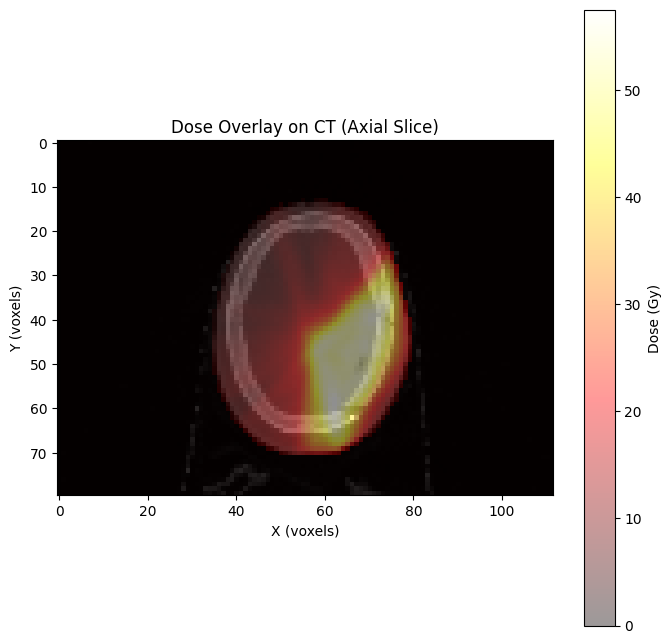

In [35]:
# Define dose isocentre
dose_isocentre_pos = np.array(RP_Files[0].BeamSequence[0].ControlPointSequence[0].IsocenterPosition) # get isocentre position in mm [x y z]
dose_isocentre_pos = np.round((dose_isocentre_pos - dose_origin)/dose_voxel_spacing).astype(int)

# Interpolate CT isocentre to dose isocentre
interpolator = RegularGridInterpolator((x, y, z), CT_Images, bounds_error = False, fill_value = 0)

# Define CT image in dose shape
CT_Images_reshaped = interpolator(points).reshape(dose_images.shape)

# Define CT slice
ct_slice_reshaped = CT_Images_reshaped[:, :, dose_isocentre_pos[2]]

# Define dose slice
dose_slice = dose_images[:, :, dose_isocentre_pos[2]]

# # Define CT voxel centre from isocentre
# # From this dose centre find corresponding CT voxel coordinates
# ct_voxel_centre = Isocentre_Pos

# # Find slice index and corresponding CT image characteristics for that slice
# slice_index = ct_voxel_centre[2]
# ct_slice = CT_Images[:, :, slice_index]

# dose_slice_resampled = dose_resampled[:, :, slice_index] # same slice index as ct_slice

# Plot
plt.figure(figsize=(8, 8))
# plt.imshow(ct_slice.T, cmap='gray', origin='upper', alpha=1.0)
plt.imshow(ct_slice_reshaped.T, cmap='gray', origin='upper', alpha=1.0)
plt.imshow(dose_slice.T/1000, cmap='hot', origin='upper', alpha=0.4)
# plt.imshow(dose_slice.T/1000, cmap='hot', origin='upper', alpha=0.4)
# plt.imshow(ct_slice.T, cmap='gray', origin='upper', alpha=1.0)
plt.title("Dose Overlay on CT (Axial Slice)")
plt.xlabel("X (voxels)")
plt.ylabel("Y (voxels)")
plt.colorbar(label="Dose (Gy)")

# contour_axial = contour_points[(slice_index-1 <= contour_points[:, 2])  & (contour_points[:,2] <= slice_index+1)] # collect points when on same slice as this figure
# x_pts, y_pts = contour_axial[:, 0], contour_axial[:, 1]
# # plt.plot(x_pts + ct_extent[0], ct_extent[3] - y_pts, 'b-', linewidth = 1)
# plt.plot(x_pts, y_pts, 'b-', linewidth = 1)

plt.show()

In [11]:
test = dose_images[:, :, 118]

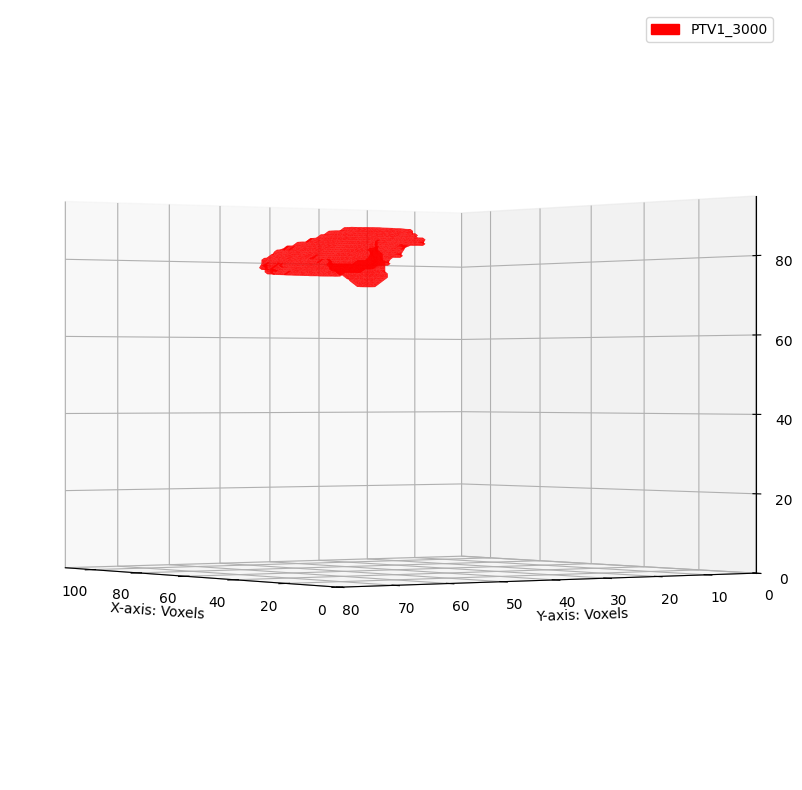

In [36]:
# Plotting with matplotlib

# Create a 3d plot for visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')

# Define colours array
colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']

for i, mask in enumerate(all_masks_resampled):
    # Extract surface mesh with marching cubes
    verts, faces, normals, values = measure.marching_cubes(mask, level=0.5)

    # Create mesh (collection of triangles?) from vertices and faces
    mesh = Poly3DCollection(verts[faces], alpha = 0.7)
    mesh.set_facecolor(colours[i % len(colours)])
    ax.add_collection3d(mesh)

# x1, y1 = np.where(dose_images[:, :, dose_isocentre_pos[2]] > 40000)
# ax.scatter(x1, y1, dose_isocentre_pos[2], c = dose_images[x1, y1, dose_isocentre_pos[2]], cmap = 'hot', s = 1)

# Set labels and axis limits
ax.set_xlabel("X-axis: Voxels")
ax.set_ylabel("Y-axis: Voxels")
ax.set_zlabel("Z-axis: Slices")
ax.set_xlim(0, mask.shape[0])
ax.set_ylim(0, mask.shape[1])
ax.set_zlim(0, mask.shape[2])

# Create a legend
legend_patches = [
    mpatches.Patch(color=colours[i % len(colours)], label=Target_Structures[i])
    for i in range(len(Target_Structures))
]
# legend_patches.append(mpatches.Patch(color=colours[i+1 % len(colours)], label="Dose > 40 Gy"))
ax.legend(handles = legend_patches, loc = 'upper right')

# Change viewing angle
ax.view_init(0,145) # elevation, azimuth

In [8]:
test = all_masks_resampled[0]

In [11]:
np.max(dose_images)

np.uint16(65535)

In [12]:
np.max(structure_dose_values)

np.uint16(63894)

In [42]:
RD_Files[1].DoseGridScaling

'0.0006096779'

Text(0.5, 1.0, 'Dose Volume Histogram')

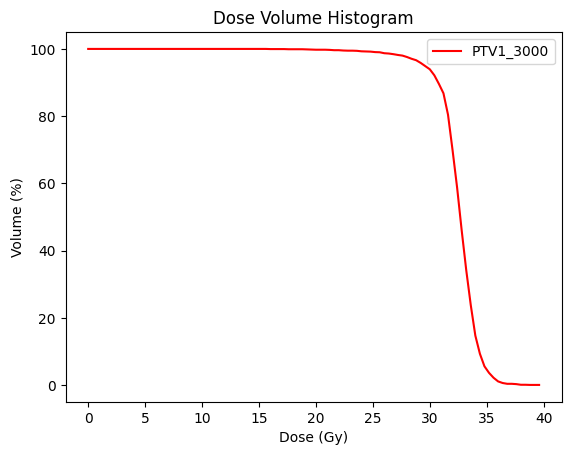

In [43]:
# Define colours array
colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black']

for i, mask in enumerate(all_masks_resampled):
    # When mask is true, then get how much dose hits there. So how much dose hits that structure
    structure_dose_values = dose_images[mask.astype(bool)]

    # Get "histogram" of stuff in bins
    counts, bin_edges = np.histogram(structure_dose_values, bins = 100, range = (0, np.max(dose_images)))

    # volume_diff = counts / counts.sum() # Differential dose

    cumulative = np.cumsum(counts[::-1])[::-1] # Cumulative dose. Number of voxels receiving >= to a dose (from bin_edges)
    volume_cum = cumulative*100/counts.sum() # Cumulative dose

    # volume = cumulative * np.prod(voxel_spacing) # Cumulative physical volume receiving dose from bin_edges

    # bin_edges = bin_edges[:-1]/1000 # exclude last max value and convert to Gy
    bin_edges = bin_edges[:-1] * RD_Files[1].DoseGridScaling # exclude last max value and convert to Gy

    plt.plot(bin_edges, volume_cum, '-', label = Target_Structures[i], color = colours[i % len(colours)])

plt.legend()
plt.xlabel("Dose (Gy)")
plt.ylabel("Volume (%)")
plt.title("Dose Volume Histogram")
# plt.show()

In [ ]:
np.max(dose_resampled)

In [ ]:
points_test = np.stack((x, y, z), axis = 0)